In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import math
from copy import deepcopy

import pandas as pd

In [2]:
class DrowsinessData(Dataset):
    def __init__(self,data, trn_val_tst, transform=None):

        # split_idx1 = int(data.shape[0]*0.6)
        # split_idx2 = int(data.shape[0]*0.8)
        # if trn_val_tst == 0:
        #     #trainloader
        #     self.X = data.iloc[0:split_idx1, 0:-1].to_numpy()
        #     self.labels = data.iloc[0:split_idx1, -1].to_numpy()
        # elif trn_val_tst == 1:
        #     #valloader
        #     self.X = data.iloc[split_idx1:split_idx2, 0:-1].to_numpy()
        #     self.labels = data.iloc[split_idx1:split_idx2, -1].to_numpy()
        # else:
        #     #testloader
        #     self.X = data.iloc[split_idx1:split_idx2, 0:-1].to_numpy()
        #     self.labels = data.iloc[split_idx1:split_idx2, -1].to_numpy()

        self.X = data.iloc[:, 0:-1].to_numpy()
        self.labels = data.iloc[:, -1].to_numpy()

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.X[idx,:]
        label = self.labels[idx]

        # if self.transform:
        #     sample = self.transform(sample)
        sample = torch.from_numpy(sample).type(torch.float32)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sample, label

In [3]:
train_data = pd.read_csv("Features_and_Labels/30s/train_features_and_labels_30s.csv")
valid_data = pd.read_csv("Features_and_Labels/30s/valid_features_and_labels_30s.csv")
test_data = pd.read_csv("Features_and_Labels/30s/test_features_and_labels_30s.csv")

# selected features from MRMR algorithm + basic features + good t-test ones
# MRMR selected features 15+3 features
# filter_features = ['MDF', 'lfnu', 'bandPower(){}_2_beta', 'bandPower(){}_1_beta', 'Sh_Ent1', 'MNF', 'Sp_ent2', 'PKF', 'nni_50', 'LZC(){}_0', 'csi', 'Sp_ent1', 'DFA(){}_2', 'ZC', 'bandPower(){}_2_alpha', 'bandPower(){}_1_delta', 'mean_hr', 'EAR_std', 'kss']

# SelectKBest features  15+3 features
# filter_features = ['bandPower(){}_1_alpha', 'bandPower(){}_1_beta', 'bandPower(){}_2_alpha', 'bandPower(){}_2_beta', 'sampEn(){}_2', 'DFA(){}_2', 'LZC(){}_0', 'Sh_Ent1', 'Sp_ent1', 'Sp_ent2', 'ZC', 'MNF', 'MDF', 'PKF', 'WENT', 'bandPower(){}_1_delta', 'mean_hr', 'EAR_std', 'kss']

# MRMR selected features (30s) 30+3 features
filter_features = ['MDF', 'bandPower(){}_1_beta', 'lfnu', 'Sh_Ent1', 'Sp_ent2', 'MNF', 'hjorthMobility(){}_1', 'Sp_ent1', 'DFA(){}_0', 'PKF', 'nni_50', 'bandPower(){}_1_alpha', 'ZC', 'DFA(){}_1', 'hjorthMobility(){}_0', 'LZC(){}_1', 'WENT', 
                   'sampEn(){}_0', 'Sp_ent0', 'hjorthComplexity(){}_1', 'hjorthComplexity(){}_0', 'blinking_rate', 'Multiscale2', 'lf_hf_ratio', 'wave_ent2', 'sampEn(){}_1', 'nni_20', 'sampEn(){}_2', 'csi', 'HFD(){}_0', 'bandPower(){}_1_delta', 'mean_hr', 'EAR_std', 'kss']

# SelectKBest features  30+3 features
# filter_features = ['bandPower(){}_1_alpha', 'bandPower(){}_1_beta', 'hjorthMobility(){}_0', 'hjorthMobility(){}_1', 'hjorthComplexity(){}_0', 'hjorthComplexity(){}_1', 'sampEn(){}_0', 'sampEn(){}_1', 'sampEn(){}_2', 'DFA(){}_0', 'DFA(){}_1', 'LZC(){}_1', 
#                   'HFD(){}_0', 'Sp_ent0', 'ApEnt1', 'SaEnt1', 'Sh_Ent1', 'Sp_ent1', 'wave_ent1', 'Multiscale2', 'Sp_ent2', 'wave_ent2', 'nni_20', 'nni_50', 'ZC', 'MNF', 'MDF', 'PKF', 'WENT', 'blinking_rate', 'bandPower(){}_1_delta', 'mean_hr', 'EAR_std', 'kss']

# MRMR selected features  50+3 features
# filter_features = ['MDF', 'bandPower(){}_1_beta', 'lfnu', 'Sh_Ent1', 'Sp_ent2', 'MNF', 'hjorthMobility(){}_1', 'Sp_ent1', 'DFA(){}_0', 'PKF', 'nni_50', 'bandPower(){}_1_alpha', 'ZC', 'DFA(){}_1', 'hjorthMobility(){}_0', 'LZC(){}_1', 'WENT', 
# 'sampEn(){}_0', 'Sp_ent0', 'hjorthComplexity(){}_1', 'hjorthComplexity(){}_0', 'blinking_rate', 'Multiscale2', 'lf_hf_ratio', 'wave_ent2', 'sampEn(){}_1', 'nni_20', 'sampEn(){}_2', 'csi', 'HFD(){}_0', 'wave_ent1', 'ApEnt1', 'bandPower(){}_1_theta', 'PFD(){}_2', 'HFD(){}_1', 
# 'EEG_std2', 'bandPower(){}_0_beta', 'Multiscale1', 'hf', 'MYOP', 'SaEnt1', 'WL', 'bandPower(){}_2_beta', 'pnni_20', 'bandPower(){}_0_alpha', 'MOE_mean', 'ACC', 'EEG_skew0', 'wave_ent0', 'LZC(){}_0', 'bandPower(){}_1_delta', 'mean_hr', 'EAR_std', 'kss']

# SelectKBest features  50+3 features
# filter_features = ['bandPower(){}_0_alpha', 'bandPower(){}_0_beta', 'bandPower(){}_1_theta', 'bandPower(){}_1_alpha', 'bandPower(){}_1_beta', 'bandPower(){}_2_beta', 'hjorthMobility(){}_0', 'hjorthMobility(){}_1', 'hjorthComplexity(){}_0', 'hjorthComplexity(){}_1', 'sampEn(){}_0',
#                     'sampEn(){}_1', 'sampEn(){}_2', 'DFA(){}_0', 'DFA(){}_1', 'PFD(){}_1', 'PFD(){}_2', 'LZC(){}_0', 'LZC(){}_1', 'HFD(){}_0', 'HFD(){}_1', 'fuzzy0', 'Sp_ent0', 'wave_ent0', 'ApEnt1', 'SaEnt1', 'Sh_Ent1', 'Multiscale1', 'Sp_ent1', 'wave_ent1', 'fuzzy2', 'Multiscale2', 
#                     'Sp_ent2', 'wave_ent2', 'EEG_std2', 'nni_20', 'nni_50', 'lf_hf_ratio', 'lfnu', 'csi', 'LOG', 'WL', 'ACC', 'ZC', 'MYOP', 'MNF', 'MDF', 'PKF', 'WENT', 'blinking_rate', 'bandPower(){}_1_delta', 'mean_hr', 'EAR_std', 'kss']

train_data = train_data.loc[:, filter_features]
valid_data = valid_data.loc[:, filter_features]
test_data = test_data.loc[:, filter_features]

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)

train_set = DrowsinessData(train_data, trn_val_tst=0) 
val_set = DrowsinessData(valid_data, trn_val_tst=1)
test_set = DrowsinessData(test_data, trn_val_tst=2)

batch_size = 100 
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

validloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

testloader =  DataLoader(test_set, batch_size=batch_size, shuffle=False)

num_features = train_set.X.shape[1]

(2226, 34)
(605, 34)
(697, 34)


In [4]:
#This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader, loss_fun):
    #initialise counter
    total_loss = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    #(More on these layer types soon!)
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            #Forward pass of image through network
            fx = model(x.to(device))
            y = y.type(torch.FloatTensor)
            
            #calculate the loss
            loss = loss_fun(fx, y.to(device))
            total_loss += loss.item()
    
    #return the accuracy from the epoch     
    return total_loss

In [5]:
def get_acc(model, device, loader):
    total_loss = 0
    total_count = 0
    correct_count = 0
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    #(More on these layer types soon!)
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            #Forward pass of image through network
            fx = model(x.to(device)).squeeze(1).cpu().numpy().tolist()
            y = y.type(torch.FloatTensor).squeeze(1).cpu().numpy().tolist()
            
            for k in range(len(y)):
                total_count += 1
                if (fx[k] >= 6.5 and y[k] >= 6.5) or (fx[k] <6.5 and y[k] <6.5):
                    correct_count += 1
    
    #return the accuracy from the epoch     
    return correct_count/total_count

In [6]:
#This function should perform a single training epoch using our training data
def train(model, device, loader, optimizer, loss_fun, loss_logger):
    
    #Set Network in train mode
    model.train()
    
    count = 0
    total_loss = 0
    
    for i, (x, y) in enumerate(loader):
        #Perform a single epoch of training on the input dataloader, logging the loss at every step 
        #Forward pass of image through network and get output
        fx = model(x.to(device))
        y = y.type(torch.FloatTensor)

        #Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))
        
        total_loss += loss.item()
        
        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()

    #log the loss PER EPOCH for plotting
    loss_logger.append(total_loss)
   
    #return the logger array       
    return loss_logger

In [7]:
class DrowsyNet(nn.Module):
    def __init__(self, channels_in):
        # calling the init function of the parent nn.Module
        super(DrowsyNet, self).__init__()
        
        # defining the fully connected layers
        print(channels_in)
        self.fc1 = nn.Linear(int(channels_in), int(channels_in//1.5))
        self.fc2 = nn.Linear(int(channels_in//1.5), int(channels_in//3))
        self.fc3 = nn.Linear(int(channels_in//3), 1)
        
    def forward(self, x):
        # Passing it through fc layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [8]:
# Creating the model
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
model = DrowsyNet(num_features).to(device)
print(model)

pytorch_total_params = sum([p.numel() for p in model.parameters()])
pytorch_total_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(pytorch_total_params, pytorch_total_trainable_params)

learning_rate =5e-4
start_epoch = 0
num_epochs = 500

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fun = nn.MSELoss()

33
DrowsyNet(
  (fc1): Linear(in_features=33, out_features=22, bias=True)
  (fc2): Linear(in_features=22, out_features=11, bias=True)
  (fc3): Linear(in_features=11, out_features=1, bias=True)
)
1013 1013


In [9]:
training_loss_logger = []
validation_loss_logger = []
testing_loss_logger = []

valid_acc_logger = []
test_acc_logger = []

highest_val_acc = -math.inf


#This cell implements our training loop
for epoch in range(start_epoch, num_epochs):
    #call the training function and pass training dataloader etc
    training_loss_logger = train(model, device, trainloader, optimizer, loss_fun, training_loss_logger)
    train_acc = get_acc(model, device, trainloader)
    #call the evaluate function and pass the dataloader for both ailidation and training
    
    valid_loss = evaluate(model, device, validloader, loss_fun)
    validation_loss_logger.append(valid_loss)
    valid_acc = get_acc(model, device, validloader)
    valid_acc_logger.append(valid_acc)


    test_loss = evaluate(model, device, testloader, loss_fun)
    testing_loss_logger.append(test_loss)
    test_acc = get_acc(model, device, testloader)
    test_acc_logger.append(test_acc)

    if epoch == 300:
        learning_rate /=10
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    # Copying the model with the highest validation accuracy
    if valid_acc > highest_val_acc:
        highest_val_acc_epoch = epoch
        highest_val_acc = valid_acc
        highest_val_acc_model = deepcopy(model)
    
    clear_output(True)
    print(f'| Epoch: {epoch+1:02} | Training Loss: {training_loss_logger[-1]:05.2f} | Validation Loss: {validation_loss_logger[-1]:05.2f} | Testing Loss: {testing_loss_logger[-1]:05.2f}')
    print(f'| Epoch: {epoch+1:02} | Training RMSE: {np.sqrt(training_loss_logger[-1]):05.2f} | Validation RMSE: {np.sqrt(validation_loss_logger[-1]):05.2f} | Testing RMSE: {np.sqrt(testing_loss_logger[-1]):05.2f}')
    print(f'| Epoch: {epoch+1:02} | Training Acc: {train_acc*100:05.2f}% | Validation Acc: {valid_acc*100:05.2f}% | Testing Acc: {test_acc*100:05.2f}%')
print("Training Complete")
print(f'Highest Validation Acc: {highest_val_acc}')

| Epoch: 500 | Training Loss: 26.43 | Validation Loss: 26.06 | Testing Loss: 39.52
| Epoch: 500 | Training RMSE: 05.14 | Validation RMSE: 05.10 | Testing RMSE: 06.29
| Epoch: 500 | Training Acc: 87.69% | Validation Acc: 62.15% | Testing Acc: 58.11%
Training Complete
Highest Validation Acc: 0.7338842975206612


Text(0.5, 1.0, 'Testing Accuracy')

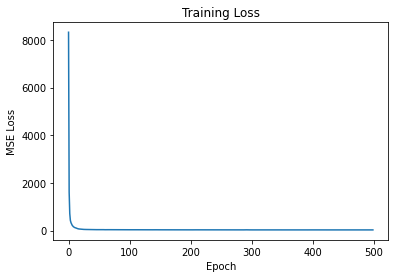

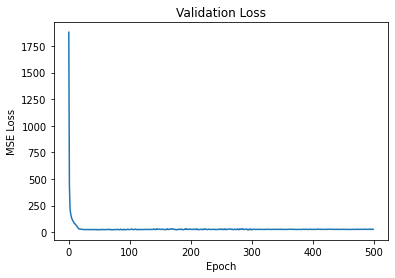

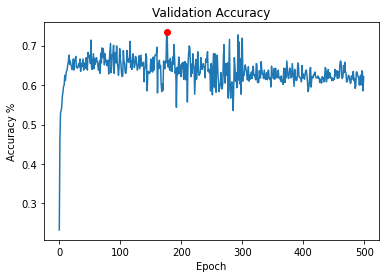

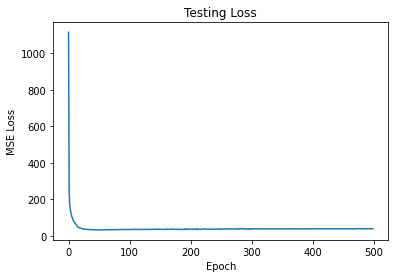

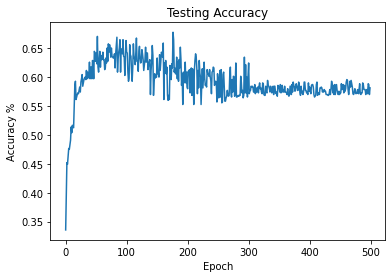

In [10]:
# Plotting
plt.figure(1)
plt.plot(training_loss_logger)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.title("Training Loss")

plt.figure(2)
plt.plot(validation_loss_logger)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.title("Validation Loss")

plt.figure(22)
plt.plot(valid_acc_logger)
plt.ylabel("Accuracy %")
plt.xlabel("Epoch")
plt.title("Validation Accuracy")
plt.plot(highest_val_acc_epoch, highest_val_acc, "ro")

plt.figure(3)
plt.plot(testing_loss_logger)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.title("Testing Loss")

plt.figure(33)
plt.plot(test_acc_logger)
plt.ylabel("Accuracy %")
plt.xlabel("Epoch")
plt.title("Testing Accuracy")

In [11]:
# Saving model
torch.save(model.state_dict(), "D:/School/Drowsiness-Detection-FYP/neural_network/best_model.pt")
